In [4]:
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
import sympy
import numpy as np
import matplotlib.pyplot as plt

In [31]:
def optimize_model(model, n=400, opt=tf.keras.optimizers.Adam(learning_rate=0.01)):
    inputs = tfq.convert_to_tensor([cirq.Circuit()])
    
    losses = []
    
    for i in range(n):
        with tf.GradientTape() as tape:
            pred = model(inputs)
            
        losses.append(pred.numpy()[0][0])
        gradients = tape.gradient(pred, model.trainable_variables)
        opt.apply_gradients(zip(gradients, model.trainable_variables))
        
    return losses

In [32]:
def make_circuit(qubits, num_l):
    num_q = len(qubits)
    num_params = num_q * num_l
    params = sympy.symbols("q0:%d"%num_params)
    circuit = cirq.Circuit()
    counter = 0
    for l in range(num_l):
        for q in range(num_q):
            circuit += cirq.rx(params[counter]).on(qubits[q])
            counter += 1
        for q in range(0, num_q - 1):
            circuit += cirq.CNOT(qubits[q], qubits[q + 1])
        circuit += cirq.CNOT(qubits[-1], qubits[0])
    return circuit

def make_model(num_q, num_l, noise_level):
    qubits = [cirq.GridQubit(0, i) for i in range(num_q)]
    circuit = make_circuit(qubits, num_l)
    ops = sum([cirq.Z(i) for i in qubits])
    inputs = tf.keras.layers.Input(shape=(), dtype=tf.string)
    initial = tf.keras.initializers.Zeros()
    if noise_level > 0:
        circuit = circuit.with_noise(cirq.depolarize(p=noise_level))
        outputs = tfq.layers.NoisyPQC(circuit, ops, repetitions=1024, sample_based=False, \
                                      differentiator=tfq.differentiators.ParameterShift(), initializer=initial)(inputs)
    else:
        outputs = tfq.layers.PQC(circuit, ops, differentiator=tfq.differentiators.Adjoint(), initializer=initial)(inputs)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model

In [33]:
rs = [0, 0.001, 0.01, 0.1, 0.2]
results = []
qubits = 4
layers = 2

for r in rs:
    print(r)
    model = make_model(qubits, layers, r)
    result = optimize_model(model)
    results.append(result)

0
0.001
0.01
0.1
0.2


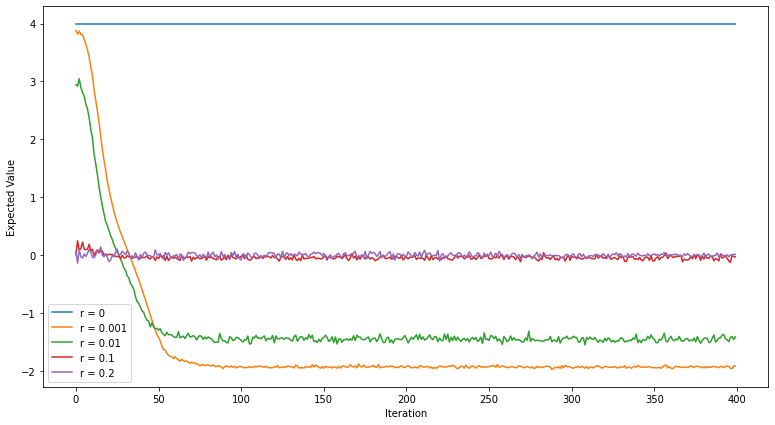

In [34]:
plt.figure(figsize=(13, 7))
for count, value in enumerate(rs):
    plt.plot(results[count], label="r = " + str(value))
    
plt.legend()
plt.ylabel("Expected Value")
plt.xlabel("Iteration")
plt.show()

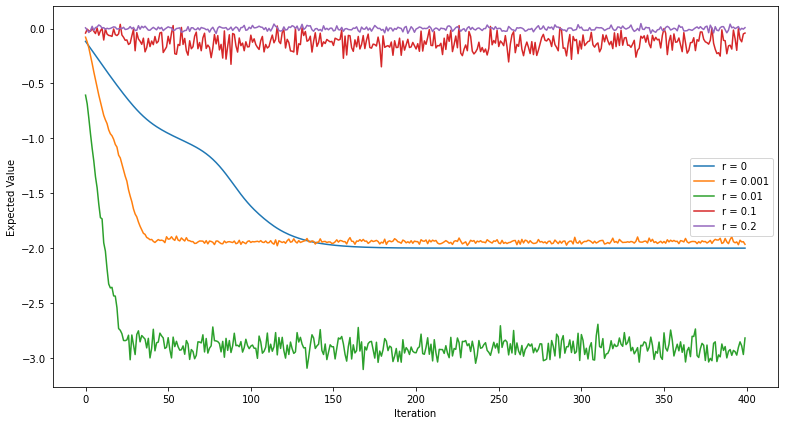

In [30]:
plt.figure(figsize=(13, 7))
for count, value in enumerate(rs):
    plt.plot(results[count], label="r = " + str(value))
    
plt.legend()
plt.ylabel("Expected Value")
plt.xlabel("Iteration")
plt.show()